In [1]:
import glob
from itertools import chain
import os
import argparse
import random
import zipfile
import gc
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from linformer import Linformer
import torchvision.transforms.functional as TF
from torch.autograd import Variable
import torch.nn.functional as F
import io
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#from vit_pytorch.efficient import ViT
#from vit_pytorch.efficient import ViT
from vit_pytorch.vit import ViT
from vit_pytorch.deepvit import DeepViT


import wandb

import sys
# import custom utilize

from util.utilize import *
import util.utilize as ut

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")

print("Path to dataset files:", path)

Path to dataset files: /home/qiyi/.cache/kagglehub/datasets/sartajbhuvaji/brain-tumor-classification-mri/versions/2


=== Testing Dataset Loading ===
Found classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Class 'glioma_tumor' found 826 images
Class 'meningioma_tumor' found 822 images
Class 'no_tumor' found 395 images
Class 'pituitary_tumor' found 827 images
Training set has 2870 images
Found classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Class 'glioma_tumor' found 100 images
Class 'meningioma_tumor' found 115 images
Class 'no_tumor' found 105 images
Class 'pituitary_tumor' found 74 images
Testing set has 394 images

Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Training set samples: 2870
Test set samples: 394

Loaded batch shape: torch.Size([4, 3, 224, 224])
Labels: [1 2 0 2]
Sample images saved to 'dataset_samples.png'

Training set class distribution:
  glioma_tumor: 826 images
  meningioma_tumor: 822 images
  no_tumor: 395 images
  pituitary_tumor: 827 images

Test set class distribution:
  glioma_tumor: 100 im

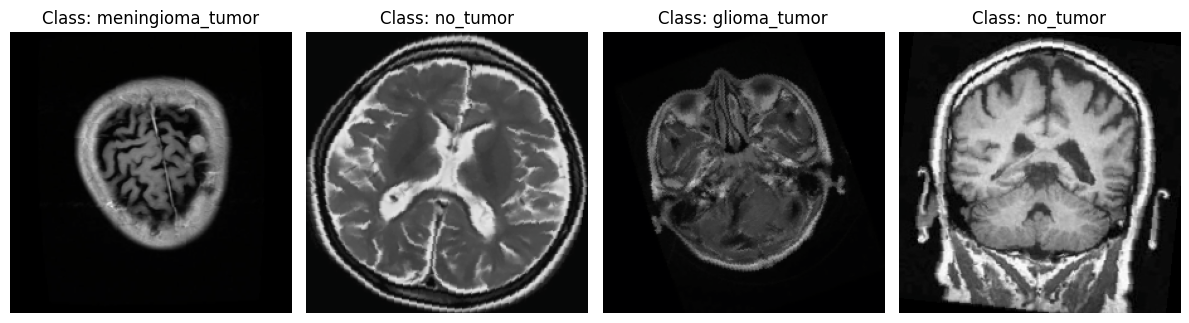

In [3]:
import os
import glob
import random
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from collections import Counter

class BrainTumorDataset(Dataset):
    """
    Brain Tumor MRI Dataset class
    Directly uses Training and Testing directories, without additional validation split
    """
    def __init__(self, root_dir, transform=None, train=True, augment=False, balance=False):
        """
        Initialization function
        
        Args:
            root_dir (string): Dataset root directory
            transform (callable, optional): Transformations to apply to images
            train (bool): Whether to load training set (True) or test set (False)
            augment (bool): Whether to perform data augmentation
            balance (bool): Whether to balance classes
        """
        self.root_dir = root_dir
        self.transform = transform
        self.train = train
        self.augment = augment
        
        # Select training or test directory
        data_dir = os.path.join(root_dir, 'Training' if train else 'Testing')
        
        if not os.path.exists(data_dir):
            raise ValueError(f"Directory does not exist: {data_dir}")
        
        # Get all classes (using directory names as class names)
        self.classes = [d for d in os.listdir(data_dir) 
                      if os.path.isdir(os.path.join(data_dir, d))]
        self.classes.sort()  # Ensure consistent class order
        
        print(f"Found classes: {self.classes}")
        
        # Load image paths and corresponding labels
        self.data = []
        
        for class_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(data_dir, class_name)
            
            # Get all image files
            files = []
            for ext in ['*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG']:
                files.extend(glob.glob(os.path.join(class_path, ext)))
            
            print(f"Class '{class_name}' found {len(files)} images")
            
            for file in files:
                self.data.append((file, class_idx))
        
        print(f"{'Training' if train else 'Testing'} set has {len(self.data)} images")
        
        # Balance classes if needed (only for training set)
        if balance and train:
            self.balance_classes()
    
    def balance_classes(self):
        """Balance classes by oversampling minority classes"""
        # Count samples per class
        class_counts = Counter([label for _, label in self.data])
        
        # Find maximum count
        max_count = max(class_counts.values())
        
        # Group data by class
        class_data = {i: [] for i in range(len(self.classes))}
        for item in self.data:
            class_data[item[1]].append(item)
        
        # Create balanced dataset
        balanced_data = []
        for class_idx, items in class_data.items():
            # Add original samples
            balanced_data.extend(items)
            
            # Add oversampled items if needed
            if len(items) < max_count:
                needed = max_count - len(items)
                oversampled = random.choices(items, k=needed)
                balanced_data.extend(oversampled)
        
        original_count = len(self.data)
        self.data = balanced_data
        print(f"Class balancing: {original_count} -> {len(self.data)} images")
    
    def __len__(self):
        """Return the number of samples in the dataset"""
        return len(self.data)
    
    def __getitem__(self, idx):
        """Get the sample at the specified index"""
        img_path, label = self.data[idx]
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Apply basic transformations
        if self.transform:
            image = self.transform(image)
        
        # Additional data augmentation (if enabled)
        if self.train and self.augment:
            # Random horizontal and vertical flips
            if random.random() > 0.5:
                image = TF.hflip(image)
            if random.random() > 0.5:
                image = TF.vflip(image)
            
            # Random rotation
            rot_factor = random.choice([0, 90, 180, 270])
            if rot_factor > 0:
                image = TF.rotate(image, rot_factor)
        
        return image, label

# Create image transformations
def get_transforms(train=True, img_size=224):
    """
    Create image transformation operations
    
    Args:
        train (bool): Whether in training mode
        img_size (int): Output image size
    
    Returns:
        torchvision.transforms: Composition of transformation operations
    """
    if train:
        return transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(20),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

def test_dataset(dataset_path):
    """
    Test whether the dataset is loaded correctly
    
    Args:
        dataset_path (str): Dataset path
    """
    print("=== Testing Dataset Loading ===")
    
    # Create training and testing datasets
    train_transform = get_transforms(train=True)
    test_transform = get_transforms(train=False)
    
    train_dataset = BrainTumorDataset(
        root_dir=dataset_path,
        transform=train_transform,
        train=True,
        augment=False,
        balance=False
    )
    
    test_dataset = BrainTumorDataset(
        root_dir=dataset_path,
        transform=test_transform,
        train=False,
        augment=False,
        balance=False
    )
    
    # Output dataset information
    print(f"\nClasses: {train_dataset.classes}")
    print(f"Training set samples: {len(train_dataset)}")
    print(f"Test set samples: {len(test_dataset)}")
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
    
    # Get a batch of data
    images, labels = next(iter(train_loader))
    
    print(f"\nLoaded batch shape: {images.shape}")
    print(f"Labels: {labels.numpy()}")
    
    # Display some image samples
    plt.figure(figsize=(12, 6))
    for i in range(min(4, len(images))):
        # Denormalize
        img = images[i].numpy().transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.title(f"Class: {train_dataset.classes[labels[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('dataset_samples.png')
    print("Sample images saved to 'dataset_samples.png'")
    
    # Count samples for each class
    train_class_counts = Counter([label for _, label in train_dataset.data])
    test_class_counts = Counter([label for _, label in test_dataset.data])
    
    print("\nTraining set class distribution:")
    for class_idx, count in train_class_counts.items():
        print(f"  {train_dataset.classes[class_idx]}: {count} images")
    
    print("\nTest set class distribution:")
    for class_idx, count in test_class_counts.items():
        print(f"  {test_dataset.classes[class_idx]}: {count} images")
    
    # Test class balancing functionality
    balanced_dataset = BrainTumorDataset(
        root_dir=dataset_path,
        transform=train_transform,
        train=True,
        augment=False,
        balance=True
    )
    
    balanced_class_counts = Counter([label for _, label in balanced_dataset.data])
    
    print("\nBalanced training set class distribution:")
    for class_idx, count in balanced_class_counts.items():
        print(f"  {balanced_dataset.classes[class_idx]}: {count} images")
    
    print("\n=== Dataset Testing Completed ===")
    return train_dataset, test_dataset

# If run as a standalone script, perform the test
if __name__ == "__main__":
    # Replace with actual dataset path
    dataset_path = "/home/qiyi/.cache/kagglehub/datasets/sartajbhuvaji/brain-tumor-classification-mri/versions/2"
    
    try:
        train_dataset, test_dataset = test_dataset(dataset_path)
        print("Dataset loaded successfully!")
    except Exception as e:
        print(f"Test failed: {str(e)}")

In [6]:
def get_model_oct_withpretrain(pretrain_out=2, outsize=15, path=None, dropout=0.25, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    print(f"Creating ViT model with {outsize} output classes on {device}")
    
    model = ViT(
        dim=1024,
        image_size=224,
        patch_size=32,
        num_classes=outsize,
        depth=12,
        heads=8,
        mlp_dim=1024,
        channels=3,
        emb_dropout=dropout,
    )
    
    model = model.to(device)
    
    print(f"Model created successfully on {next(model.parameters()).device}")
    
    return model

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import time
import pandas as pd

import util.utilize as ut

# Set random seed to ensure reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Calculate evaluation metrics
def calculate_metrics(y_true, y_pred):
    # Ensure inputs are lists or arrays
    if not isinstance(y_true, (list, np.ndarray)):
        y_true = [y_true]
    if not isinstance(y_pred, (list, np.ndarray)):
        y_pred = [y_pred]
    
    # Calculate confusion matrix
    try:
        cm = confusion_matrix(y_true, y_pred)
        
        # Calculate sensitivity and specificity for each class
        sensitivities = []
        specificities = []
        
        for i in range(len(cm)):
            # True positive for class i
            tp = cm[i, i]
            # False negative for class i
            fn = np.sum(cm[i, :]) - tp
            # False positive for class i
            fp = np.sum(cm[:, i]) - tp
            # True negative for class i
            tn = np.sum(cm) - tp - fn - fp
            
            # Calculate sensitivity (recall) = TP / (TP + FN)
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            sensitivities.append(sensitivity)
            
            # Calculate specificity = TN / (TN + FP)
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            specificities.append(specificity)
        
        # Calculate overall metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
        
        # Calculate average sensitivity and specificity
        mean_sensitivity = np.mean(sensitivities)
        mean_specificity = np.mean(specificities)
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'sensitivity': mean_sensitivity,
            'specificity': mean_specificity,
            'confusion_matrix': cm
        }
    except Exception as e:
        print(f"Error calculating metrics: {str(e)}")
        print(f"y_true shape: {np.shape(y_true)}, y_pred shape: {np.shape(y_pred)}")
        print(f"y_true: {y_true[:10]}, y_pred: {y_pred[:10]}")
        return {
            'accuracy': 0,
            'precision': 0,
            'recall': 0,
            'f1_score': 0,
            'sensitivity': 0,
            'specificity': 0,
            'confusion_matrix': None
        }

# Custom loss function
def get_loss_fn(bce_weight=0.5, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def loss_fn(output, target, pos_weight=None):
        if pos_weight is None:
            pos_weight = torch.ones(output.size(1)).to(device)
        
        # Ensure target has the correct shape
        if len(target.shape) == 1:
            # Convert integer classes to one-hot encoding
            one_hot = torch.zeros(target.size(0), output.size(1), device=device)
            one_hot.scatter_(1, target.unsqueeze(1), 1)
            target = one_hot
        
        # Ensure all tensors are on the same device
        target = target.to(device)
        output = output.to(device)
        pos_weight = pos_weight.to(device)
        
        # BCE loss
        bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)(output, target)
        
        # MSE loss - using argmax as regression target
        output_idx = torch.argmax(output, dim=1).float()
        target_idx = torch.argmax(target, dim=1).float()
        mse_loss = nn.MSELoss()(output_idx, target_idx)
        
        # Combined loss
        return bce_weight * bce_loss + (1 - bce_weight) * mse_loss
    
    return loss_fn

# Save checkpoint function
def save_checkpoint(model, optimizer, epoch, accuracy, save_path):
    os.makedirs(save_path, exist_ok=True)
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'accuracy': accuracy
    }
    torch.save(checkpoint, os.path.join(save_path, f'epoch_{epoch}_acc_{accuracy:.4f}.pt'))

# Evaluation function
def evaluate(model, data_loader, criterion, device):
    model.eval()
    val_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in tqdm(data_loader, desc="Evaluating"):
            # Convert to appropriate type and device
            data = data.to(torch.float32).to(device)
            target = target.to(device)
            
            # Forward pass
            output = model(data)
            
            # Calculate loss
            loss = criterion(output, target)
            val_loss += loss.item()
            
            # Get predictions
            preds = torch.argmax(output, dim=1).cpu().numpy()
            if len(target.shape) > 1:
                target = torch.argmax(target, dim=1)
            targets = target.cpu().numpy()
            
            all_preds.extend(preds)
            all_targets.extend(targets)
    
    # Calculate average loss
    val_loss /= len(data_loader)
    
    # Calculate metrics
    metrics = calculate_metrics(all_targets, all_preds)
    metrics['loss'] = val_loss
    
    return metrics

# Train one epoch
def train_one_epoch(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    train_loss = 0
    all_preds = []
    all_targets = []
    
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}")):
        # Convert to appropriate type and device
        data = data.to(torch.float32).to(device)
        target = target.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        
        # Calculate loss
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Accumulate loss
        train_loss += loss.item()
        
        # Get predictions
        preds = torch.argmax(output, dim=1).cpu().numpy()
        if len(target.shape) > 1:
            target = torch.argmax(target, dim=1)
        targets = target.cpu().numpy()
        
        all_preds.extend(preds)
        all_targets.extend(targets)
        
        # Print every 10 batches
        if (batch_idx + 1) % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx + 1}/{len(train_loader)}] '
                  f'Loss: {loss.item():.6f}')
    
    # Calculate average loss
    train_loss /= len(train_loader)
    
    # Calculate metrics
    metrics = calculate_metrics(all_targets, all_preds)
    metrics['loss'] = train_loss
    
    return metrics

# Complete training function
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, 
                device, epochs, save_path='./checkpoints', eval_every=5):
    # Create save directory
    os.makedirs(save_path, exist_ok=True)
    
    # Save training history
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_sensitivity': [],
        'val_specificity': []
    }
    
    # Track best model
    best_val_acc = 0
    best_model_path = None
    
    # Timing
    start_time = time.time()
    
    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")
        
        # Train one epoch
        train_metrics = train_one_epoch(model, train_loader, optimizer, criterion, device, epoch)
        
        # Update learning rate
        scheduler.step()
        
        # Save training metrics
        history['train_loss'].append(train_metrics['loss'])
        history['train_accuracy'].append(train_metrics['accuracy'])
        
        # Evaluate model
        if epoch % eval_every == 0 or epoch == epochs:
            print("\nEvaluating on validation set...")
            val_metrics = evaluate(model, val_loader, criterion, device)
            
            # Save validation metrics
            history['val_loss'].append(val_metrics['loss'])
            history['val_accuracy'].append(val_metrics['accuracy'])
            history['val_sensitivity'].append(val_metrics['sensitivity'])
            history['val_specificity'].append(val_metrics['specificity'])
            
            # Print evaluation results
            print(f"Validation Loss: {val_metrics['loss']:.6f}, "
                  f"Accuracy: {val_metrics['accuracy']:.4f}, "
                  f"Sensitivity: {val_metrics['sensitivity']:.4f}, "
                  f"Specificity: {val_metrics['specificity']:.4f}")
            
            # Save confusion matrix
            if val_metrics['confusion_matrix'] is not None:
                print("Confusion Matrix:")
                print(val_metrics['confusion_matrix'])
            
            # Save best model
            if val_metrics['accuracy'] > best_val_acc:
                best_val_acc = val_metrics['accuracy']
                best_model_path = os.path.join(save_path, f'best_model_acc_{best_val_acc:.4f}.pt')
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'accuracy': best_val_acc,
                    'sensitivity': val_metrics['sensitivity'],
                    'specificity': val_metrics['specificity']
                }, best_model_path)
                print(f"Saved best model with accuracy: {best_val_acc:.4f}")
        
        # Save model every epoch
        checkpoint_path = os.path.join(save_path, f'epoch_{epoch}.pt')
        torch.save(model.state_dict(), checkpoint_path)
    
    # Calculate total training time
    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time/60:.2f} minutes")
    print(f"Best validation accuracy: {best_val_acc:.4f}")
    
    # Return training history and best model path
    return history, best_model_path

# Create a vanilla ViT model without loading pretrained weights
def get_model_oct_withpretrain(pretrain_out=2, outsize=15, path=None, dropout=0.25, device=None):
    '''
    Create a vanilla Vision Transformer model without loading pretrained weights
    outsize: number of output classes
    '''
    # Use provided device or default to available GPU/CPU
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    print(f"Creating ViT model with {outsize} output classes on {device}")
    
    # Create model with correct output size
    from vit_pytorch.vit import ViT
    
    model = ViT(
        dim=1024,
        image_size=224,
        patch_size=32,
        num_classes=outsize,  # directly use target class count
        depth=12,
        heads=8,
        mlp_dim=1024,
        channels=3,
        emb_dropout=dropout,
    )
    
    # Ensure model is on the correct device
    model = model.to(device)
    
    print(f"Model created successfully on {next(model.parameters()).device}")
    
    return model

# Main function
def main():
    # Set random seed
    set_seed(42)
    
    # Configurations
    configs = [
        {'lr': 3e-4, 'isaug': True, 'isbalval': False, 'isbalbce': False, 'randz': False, 'bce_weight': 0.99},
    ]
    
    # Dataset path
    DATASET_PATH = "/home/qiyi/.cache/kagglehub/datasets/sartajbhuvaji/brain-tumor-classification-mri/versions/2"
    
    # Import BrainTumorDataset and get_transforms
    from brain_tumor_dataset import BrainTumorDataset, get_transforms
    
    # Function to get datasets
    def get_brain_tumor_data(path, aug_class=True, bal_val=False):
        train_transform = get_transforms(train=True)
        test_transform = get_transforms(train=False)
        
        train_dataset = BrainTumorDataset(
            root_dir=path,
            transform=train_transform,
            train=True,
            augment=aug_class,
            balance=aug_class
        )
        
        test_dataset = BrainTumorDataset(
            root_dir=path,
            transform=test_transform,
            train=False,
            augment=False,
            balance=bal_val
        )
        
        return train_dataset, test_dataset
    
    # Loop through configurations
    for config in configs:
        lr = config['lr']
        isaug = config['isaug']
        isbalval = config['isbalval']
        isbalbce = config['isbalbce']
        bce_weight = config['bce_weight']
        
        # Create run name
        run_name = f"brain_tumor_vit_lr{lr}_isaug{1 if isaug else 0}_isbalval{1 if isbalval else 0}_bceWeight{bce_weight}"
        print(f"\nStarting training run: {run_name}")
        
        # Create temporary dataset to get class count
        temp_dataset = BrainTumorDataset(root_dir=DATASET_PATH, transform=None, train=True)
        num_classes = len(temp_dataset.classes)
        print(f"Detected {num_classes} classes in the dataset: {temp_dataset.classes}")
        
        # Device
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")
        
        # Get model - using the vanilla version
        model = get_model_oct_withpretrain(
            outsize=num_classes, 
            dropout=0.15,
            device=device
        )
        
        # Get datasets
        train_dataset, test_dataset = get_brain_tumor_data(
            path=DATASET_PATH, 
            aug_class=isaug, 
            bal_val=isbalval
        )
        
        # Create data loaders
        train_loader = DataLoader(
            train_dataset, 
            batch_size=32, 
            shuffle=True, 
            num_workers=4,
            pin_memory=True
        )
        
        val_loader = DataLoader(
            test_dataset, 
            batch_size=32, 
            shuffle=False, 
            num_workers=4,
            pin_memory=True
        )
        
        # Show dataset information
        print(f"Training set size: {len(train_dataset)}")
        print(f"Validation set size: {len(test_dataset)}")
        
        # Loss function
        criterion = get_loss_fn(bce_weight=bce_weight, device=device)
        
        # Optimizer
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
        
        # Learning rate scheduler
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, 
            T_max=100,  # total epochs
            eta_min=3e-5  # minimum learning rate
        )
        
        # Save path
        save_path = f'./brain_tumor_ckpts/{run_name}'
        
        # Train model
        history, best_model_path = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=optimizer,
            criterion=criterion,
            scheduler=scheduler,
            device=device,
            epochs=100,  # training epochs
            save_path=save_path,
            eval_every=5  # evaluate every 5 epochs
        )
        
        # Save training history
        history_df = pd.DataFrame(history)
        history_df.to_csv(f'{save_path}/training_history.csv', index=False)
        
        print(f"\nTraining completed for {run_name}")
        print(f"Best model saved at: {best_model_path}")
        print("-" * 80)

if __name__ == "__main__":
    main()


Starting training run: brain_tumor_vit_lr0.0003_isaug1_isbalval0_bceWeight0.99
Found classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Class 'glioma_tumor' found 826 images
Class 'meningioma_tumor' found 822 images
Class 'no_tumor' found 395 images
Class 'pituitary_tumor' found 827 images
Training set has 2870 images
Detected 4 classes in the dataset: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Using device: cuda:0
Creating ViT model with 4 output classes on cuda:0
sefl= torch.Size([50, 1024]) torch.Size([1, 1024]) Dropout(p=0.15, inplace=False)
Model created successfully on cuda:0
Found classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Class 'glioma_tumor' found 826 images
Class 'meningioma_tumor' found 822 images
Class 'no_tumor' found 395 images
Class 'pituitary_tumor' found 827 images
Training set has 2870 images
Class balancing: 2870 -> 3308 images
Found classes: ['glioma_tumor', 'meningioma_tumor', 'no

Epoch 1:  15%|█▌        | 16/104 [00:00<00:03, 28.51it/s]

Train Epoch: 1 [10/104] Loss: 0.596823


Epoch 1:  24%|██▍       | 25/104 [00:00<00:02, 34.29it/s]

Train Epoch: 1 [20/104] Loss: 0.616189


Epoch 1:  34%|███▎      | 35/104 [00:01<00:01, 37.69it/s]

Train Epoch: 1 [30/104] Loss: 0.506812


Epoch 1:  43%|████▎     | 45/104 [00:01<00:01, 38.86it/s]

Train Epoch: 1 [40/104] Loss: 0.519436


Epoch 1:  56%|█████▌    | 58/104 [00:01<00:01, 39.06it/s]

Train Epoch: 1 [50/104] Loss: 0.515735


Epoch 1:  63%|██████▎   | 66/104 [00:02<00:00, 38.22it/s]

Train Epoch: 1 [60/104] Loss: 0.536750


Epoch 1:  71%|███████   | 74/104 [00:02<00:00, 37.88it/s]

Train Epoch: 1 [70/104] Loss: 0.529105


Epoch 1:  83%|████████▎ | 86/104 [00:02<00:00, 38.12it/s]

Train Epoch: 1 [80/104] Loss: 0.512269


Epoch 1:  90%|█████████ | 94/104 [00:02<00:00, 37.68it/s]

Train Epoch: 1 [90/104] Loss: 0.608232


Epoch 1: 100%|██████████| 104/104 [00:03<00:00, 34.48it/s]


Train Epoch: 1 [100/104] Loss: 0.554517

Epoch 2/100


Epoch 2:  13%|█▎        | 14/104 [00:00<00:02, 31.30it/s]

Train Epoch: 2 [10/104] Loss: 0.535078


Epoch 2:  26%|██▌       | 27/104 [00:00<00:02, 36.39it/s]

Train Epoch: 2 [20/104] Loss: 0.536581


Epoch 2:  34%|███▎      | 35/104 [00:01<00:01, 37.82it/s]

Train Epoch: 2 [30/104] Loss: 0.505706


Epoch 2:  42%|████▏     | 44/104 [00:01<00:01, 38.28it/s]

Train Epoch: 2 [40/104] Loss: 0.518578


Epoch 2:  55%|█████▍    | 57/104 [00:01<00:01, 38.05it/s]

Train Epoch: 2 [50/104] Loss: 0.495614


Epoch 2:  62%|██████▎   | 65/104 [00:01<00:01, 37.74it/s]

Train Epoch: 2 [60/104] Loss: 0.522235


Epoch 2:  75%|███████▌  | 78/104 [00:02<00:00, 38.55it/s]

Train Epoch: 2 [70/104] Loss: 0.425843


Epoch 2:  83%|████████▎ | 86/104 [00:02<00:00, 38.72it/s]

Train Epoch: 2 [80/104] Loss: 0.425384


Epoch 2:  90%|█████████ | 94/104 [00:02<00:00, 37.98it/s]

Train Epoch: 2 [90/104] Loss: 0.499962


Epoch 2: 100%|██████████| 104/104 [00:02<00:00, 36.04it/s]


Train Epoch: 2 [100/104] Loss: 0.515309

Epoch 3/100


Epoch 3:  16%|█▋        | 17/104 [00:00<00:02, 32.22it/s]

Train Epoch: 3 [10/104] Loss: 0.472791


Epoch 3:  24%|██▍       | 25/104 [00:00<00:02, 35.70it/s]

Train Epoch: 3 [20/104] Loss: 0.407337


Epoch 3:  36%|███▌      | 37/104 [00:01<00:01, 38.10it/s]

Train Epoch: 3 [30/104] Loss: 0.449190


Epoch 3:  43%|████▎     | 45/104 [00:01<00:01, 38.24it/s]

Train Epoch: 3 [40/104] Loss: 0.527674


Epoch 3:  55%|█████▍    | 57/104 [00:01<00:01, 37.74it/s]

Train Epoch: 3 [50/104] Loss: 0.500221


Epoch 3:  62%|██████▎   | 65/104 [00:01<00:01, 37.94it/s]

Train Epoch: 3 [60/104] Loss: 0.466383


Epoch 3:  74%|███████▍  | 77/104 [00:02<00:00, 37.64it/s]

Train Epoch: 3 [70/104] Loss: 0.489512


Epoch 3:  82%|████████▏ | 85/104 [00:02<00:00, 36.99it/s]

Train Epoch: 3 [80/104] Loss: 0.445336


Epoch 3:  93%|█████████▎| 97/104 [00:02<00:00, 37.66it/s]

Train Epoch: 3 [90/104] Loss: 0.347632


Epoch 3: 100%|██████████| 104/104 [00:02<00:00, 35.46it/s]


Train Epoch: 3 [100/104] Loss: 0.429776

Epoch 4/100


Epoch 4:  13%|█▎        | 14/104 [00:00<00:02, 32.15it/s]

Train Epoch: 4 [10/104] Loss: 0.368026


Epoch 4:  25%|██▌       | 26/104 [00:00<00:02, 36.05it/s]

Train Epoch: 4 [20/104] Loss: 0.459680


Epoch 4:  33%|███▎      | 34/104 [00:01<00:01, 36.22it/s]

Train Epoch: 4 [30/104] Loss: 0.472524


Epoch 4:  45%|████▌     | 47/104 [00:01<00:01, 39.08it/s]

Train Epoch: 4 [40/104] Loss: 0.481880


Epoch 4:  54%|█████▍    | 56/104 [00:01<00:01, 39.02it/s]

Train Epoch: 4 [50/104] Loss: 0.409597


Epoch 4:  62%|██████▏   | 64/104 [00:01<00:01, 38.42it/s]

Train Epoch: 4 [60/104] Loss: 0.429776


Epoch 4:  73%|███████▎  | 76/104 [00:02<00:00, 37.25it/s]

Train Epoch: 4 [70/104] Loss: 0.493700


Epoch 4:  81%|████████  | 84/104 [00:02<00:00, 37.73it/s]

Train Epoch: 4 [80/104] Loss: 0.386517


Epoch 4:  92%|█████████▏| 96/104 [00:02<00:00, 36.66it/s]

Train Epoch: 4 [90/104] Loss: 0.383373


Epoch 4: 100%|██████████| 104/104 [00:02<00:00, 35.58it/s]

Train Epoch: 4 [100/104] Loss: 0.584282



Epoch 5/100


Epoch 5:  16%|█▋        | 17/104 [00:00<00:02, 32.98it/s]

Train Epoch: 5 [10/104] Loss: 0.371537


Epoch 5:  24%|██▍       | 25/104 [00:00<00:02, 34.53it/s]

Train Epoch: 5 [20/104] Loss: 0.454578


Epoch 5:  36%|███▌      | 37/104 [00:01<00:01, 36.54it/s]

Train Epoch: 5 [30/104] Loss: 0.514421


Epoch 5:  44%|████▍     | 46/104 [00:01<00:01, 38.04it/s]

Train Epoch: 5 [40/104] Loss: 0.488106


Epoch 5:  52%|█████▏    | 54/104 [00:01<00:01, 38.00it/s]

Train Epoch: 5 [50/104] Loss: 0.468182


Epoch 5:  63%|██████▎   | 66/104 [00:01<00:00, 38.32it/s]

Train Epoch: 5 [60/104] Loss: 0.433135


Epoch 5:  71%|███████   | 74/104 [00:02<00:00, 37.18it/s]

Train Epoch: 5 [70/104] Loss: 0.490156


Epoch 5:  83%|████████▎ | 86/104 [00:02<00:00, 37.70it/s]

Train Epoch: 5 [80/104] Loss: 0.443163


Epoch 5:  90%|█████████ | 94/104 [00:02<00:00, 37.78it/s]

Train Epoch: 5 [90/104] Loss: 0.535067


Epoch 5: 100%|██████████| 104/104 [00:02<00:00, 35.67it/s]


Train Epoch: 5 [100/104] Loss: 0.472389

Evaluating on validation set...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 38.01it/s]


Validation Loss: 0.813249, Accuracy: 0.2056, Sensitivity: 0.2061, Specificity: 0.7299
Confusion Matrix:
[[  1  18  69  12]
 [  0   4 105   6]
 [  0  31  62  12]
 [  3  13  44  14]]
Saved best model with accuracy: 0.2056

Epoch 6/100


Epoch 6:  13%|█▎        | 14/104 [00:00<00:02, 31.31it/s]

Train Epoch: 6 [10/104] Loss: 0.423760


Epoch 6:  25%|██▌       | 26/104 [00:00<00:02, 35.69it/s]

Train Epoch: 6 [20/104] Loss: 0.490821


Epoch 6:  34%|███▎      | 35/104 [00:01<00:01, 37.86it/s]

Train Epoch: 6 [30/104] Loss: 0.420674


Epoch 6:  45%|████▌     | 47/104 [00:01<00:01, 37.27it/s]

Train Epoch: 6 [40/104] Loss: 0.363023


Epoch 6:  54%|█████▍    | 56/104 [00:01<00:01, 38.82it/s]

Train Epoch: 6 [50/104] Loss: 0.564295


Epoch 6:  62%|██████▎   | 65/104 [00:01<00:00, 39.18it/s]

Train Epoch: 6 [60/104] Loss: 0.424485


Epoch 6:  70%|███████   | 73/104 [00:02<00:00, 37.18it/s]

Train Epoch: 6 [70/104] Loss: 0.487246


Epoch 6:  83%|████████▎ | 86/104 [00:02<00:00, 36.36it/s]

Train Epoch: 6 [80/104] Loss: 0.485572


Epoch 6:  91%|█████████▏| 95/104 [00:02<00:00, 37.86it/s]

Train Epoch: 6 [90/104] Loss: 0.526031


Epoch 6: 100%|██████████| 104/104 [00:02<00:00, 35.47it/s]


Train Epoch: 6 [100/104] Loss: 0.452532

Epoch 7/100


Epoch 7:  16%|█▋        | 17/104 [00:00<00:02, 33.86it/s]

Train Epoch: 7 [10/104] Loss: 0.398894


Epoch 7:  24%|██▍       | 25/104 [00:00<00:02, 35.65it/s]

Train Epoch: 7 [20/104] Loss: 0.419034


Epoch 7:  27%|██▋       | 28/104 [00:00<00:02, 30.89it/s]


KeyboardInterrupt: 